In [1]:
!pip install --upgrade ibm-watson-machine-learning   | tail -n 1
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install --upgrade ibm-aigov-facts-client | tail -n 1
!pip install --upgrade evaluate --no-cache | tail -n 1
!pip install --upgrade rouge_score --no-cache | tail -n 1
!pip install --upgrade textstat --no-cache | tail -n 1
!pip install --upgrade sacrebleu --no-cache | tail -n 1
!pip install --upgrade sacremoses --no-cache | tail -n 1
!pip install --upgrade datasets==2.10.0 --no-cache | tail -n 1
!pip install --upgrade torchmetrics --no-cache | tail -n 1
!pip install --upgrade pyspellchecker spacy --no-cache | tail -n 1

In [2]:
import spacy
spacy.cli.download("en_core_web_sm")
!python -m nltk.downloader punkt
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
use_cpd = False
CLOUD_API_KEY = "xxx"
IAM_URL="https://iam.ng.bluemix.net/oidc/token"

from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator,CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

if use_cpd:
    authenticator = CloudPakForDataAuthenticator(
            url=WOS_CREDENTIALS['url'],
            username=WOS_CREDENTIALS['username'],
            apikey=WOS_CREDENTIALS['apikey'],
            disable_ssl_verification=True,
        )
    
    client = APIClient(service_url=WOS_CREDENTIALS['url'],authenticator=authenticator)
    print(client.version)
else:
    authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY)
    client = APIClient(authenticator=authenticator)
    print(client.version)

3.0.41


In [4]:
PROJECT_ID = "ab37b074-2174-4cba-ab6c-8545266e3cf2" # YOUR_PROJECT_ID

In [5]:
use_existing_space = True # Set it as False if user wants to create a new space

In [6]:
import json
from ibm_watson_machine_learning import APIClient
WML_CREDENTIALS = {
                "url": "https://us-south.ml.cloud.ibm.com",
                "apikey": CLOUD_API_KEY
}
wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

'1.0.360'

In [7]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  --------------------  ------------------------
ID                                    NAME                  CREATED
066d6f31-9f63-4498-aa17-cf8af695bac8  niklas-test           2024-09-12T15:08:59.866Z
c5426b24-db66-4ed8-a0dd-bfde5e057457  niklas-claim-summary  2024-09-12T09:49:34.381Z
f9c9a838-28b0-4504-ba7d-d8e303ea1bae  watsonx-demo          2024-09-10T15:59:37.648Z
------------------------------------  --------------------  ------------------------


,ID,NAME,CREATED
0,066d6f31-9f63-4498-aa17-cf8af695bac8,niklas-test,2024-09-12T15:08:59.866Z
1,c5426b24-db66-4ed8-a0dd-bfde5e057457,niklas-claim-summary,2024-09-12T09:49:34.381Z
2,f9c9a838-28b0-4504-ba7d-d8e303ea1bae,watsonx-demo,2024-09-10T15:59:37.648Z


In [8]:
space_id = "066d6f31-9f63-4498-aa17-cf8af695bac8"

In [9]:
WML_INSTANCE_NAME =  "Watson Machine Learning" # YOUR_WML_INSTANCE_NAME
WML_CRN =  "crn:v1:bluemix:public:pm-20:us-south:a/000e0d2204334dc99d336a3bc0cd99be:4f9ee7b9-c9d2-446a-9de1-1e3ca2725e98::"
COS_RESOURCE_CRN = "crn:v1:bluemix:public:cloud-object-storage:global:a/000e0d2204334dc99d336a3bc0cd99be:37b295a1-3e57-4241-87e6-67724af28139::"

In [10]:
wml_client.set.default_space(space_id)
print(space_id)

066d6f31-9f63-4498-aa17-cf8af695bac8


In [11]:
import requests, json
def generate_access_token():
    headers={}
    headers["Content-Type"] = "application/x-www-form-urlencoded"
    headers["Accept"] = "application/json"
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": CLOUD_API_KEY,
        "response_type": "cloud_iam"
    }
    response = requests.post("https://iam.cloud.ibm.com/identity/token", data=data, headers=headers)
    json_data = response.json()
    iam_access_token = json_data["access_token"]
    return iam_access_token

iam_access_token = generate_access_token()

In [12]:
!pip install --upgrade ibm-aigov-facts-client | tail -n 1

from ibm_aigov_facts_client import AIGovFactsClient

facts_client = AIGovFactsClient(
    api_key=CLOUD_API_KEY,
    container_id=PROJECT_ID,
    container_type="project",
    disable_tracing=True
)

In [13]:
from ibm_aigov_facts_client import DetachedPromptTemplate, PromptTemplate

detached_information = DetachedPromptTemplate(
    prompt_id="detached_prompt",
    model_id="google/flan-t5-base",
    model_provider="Hugging Face",
    model_name="google/flan-t5-base",
    model_url="https://huggingface.co/google/flan-t5-base",
    prompt_url="prompt_url",
    prompt_additional_info={"model_owner": "huggingface"}
)

task_id = "summarization"
name = "External prompt sample (google/flan-t5-base HF) V2.0"
description = "My first detached prompt"
model_id = "google/flan-t5-base"

# define parameters for PromptTemplate
prompt_variables = {"original_text": ""}
input = "{original_text}"
input_prefix= "Input:"
output_prefix= "Output:"

prompt_template = PromptTemplate(
    input=input,
    prompt_variables=prompt_variables,
    input_prefix=input_prefix,
    output_prefix=output_prefix
)

pta_details = facts_client.assets.create_detached_prompt(
    model_id=model_id,
    task_id=task_id,
    name=name,
    description=description,
    prompt_details=prompt_template,
    detached_information=detached_information
)
project_pta_id = pta_details.to_dict()["asset_id"]

2024/09/19 10:53:13 INFO : ------------------------------ Detached Prompt Creation Started ------------------------------
2024/09/19 10:53:14 INFO : The detached prompt with ID e661e821-bf39-4279-86dc-b8c03b94f390 was created successfully in container_id ab37b074-2174-4cba-ab6c-8545266e3cf2.


In [14]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

SERVICE_URL = "https://api.aiopenscale.cloud.ibm.com"
IAM_URL = "https://iam.cloud.ibm.com"

service_instance_id = None # Update this to refer to a particular service instance
authenticator = IAMAuthenticator(
    apikey=CLOUD_API_KEY,
    url=IAM_URL
)
wos_client = APIClient(
    authenticator=authenticator,
    service_url=SERVICE_URL,
    service_instance_id=service_instance_id
)
data_mart_id = wos_client.service_instance_id
print(wos_client.version)

3.0.41


In [15]:
label_column = "reference_summary"
operational_space_id = "development"
problem_type = "summarization"
input_data_type = "unstructured_text"

monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration": {                    
            }
        }
    }
}

response = wos_client.monitor_instances.mrm.execute_prompt_setup(
    prompt_template_asset_id=project_pta_id, 
    project_id=PROJECT_ID,
    label_column=label_column,
    operational_space_id=operational_space_id, 
    problem_type=problem_type,
    input_data_type=input_data_type, 
    supporting_monitors=monitors, 
    background_mode=False
)

result = response.result
result.to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup e661e821-bf39-4279-86dc-b8c03b94f390 




running.....
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': 'e661e821-bf39-4279-86dc-b8c03b94f390',
 'project_id': 'ab37b074-2174-4cba-ab6c-8545266e3cf2',
 'deployment_id': 'e75067a0-9fe1-4225-824a-d90061d34d6a',
 'service_provider_id': '37e697de-718a-4f10-b4b5-e3dec9fa6338',
 'subscription_id': 'eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769',
 'mrm_monitor_instance_id': '902876bc-7d0c-474b-88ee-5f458c14ba48',
 'start_time': '2024-09-19T10:53:21.944325Z',
 'end_time': '2024-09-19T10:53:57.713014Z',
 'status': {'state': 'FINISHED'}}

In [16]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=PROJECT_ID
)

result = response.result
result_json = result.to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup. The response is {}".format(result_json))
else:
    print("Prompt setup failed. The response is {}".format(result_json))

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method
Finished prompt setup. The response is {'prompt_template_asset_id': 'e661e821-bf39-4279-86dc-b8c03b94f390', 'project_id': 'ab37b074-2174-4cba-ab6c-8545266e3cf2', 'deployment_id': 'e75067a0-9fe1-4225-824a-d90061d34d6a', 'service_provider_id': '37e697de-718a-4f10-b4b5-e3dec9fa6338', 'subscription_id': 'eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769', 'mrm_monitor_instance_id': '902876bc-7d0c-474b-88ee-5f458c14ba48', 'start_time': '2024-09-19T10:53:21.944325Z', 'end_time': '2024-09-19T10:53:57.713014Z', 'status': {'state': 'FINISHED'}}


In [17]:
subscription_id = result_json["subscription_id"]
mrm_monitor_instance_id = result_json["mrm_monitor_instance_id"]

In [18]:
wos_client.monitor_instances.show(target_target_id=subscription_id)

cb0dce18-46f9-4618-a077-4e2c8dbdf57b,active,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769,subscription,model_health,2024-09-19 10:53:46.863000+00:00,4a76a1a3-4c1e-4b45-bb60-e7cfdebae438
cb0dce18-46f9-4618-a077-4e2c8dbdf57b,active,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769,subscription,generative_ai_quality,2024-09-19 10:53:42.540000+00:00,d652599f-2df8-41ec-b91b-0fca06638b4e
cb0dce18-46f9-4618-a077-4e2c8dbdf57b,active,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769,subscription,mrm,2024-09-19 10:53:49.949000+00:00,902876bc-7d0c-474b-88ee-5f458c14ba48


In [19]:
import pandas as pd

!rm summarisation.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv

test_data_path = "summarisation.csv"
llm_data = pd.read_csv(test_data_path)
#llm_data.head()

rm: cannot remove 'summarisation.csv': No such file or directory
--2024-09-19 10:59:08--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27115 (26K) [text/plain]
Saving to: ‘summarisation.csv’

summarisation.csv   100%[===================>]  26.48K  --.-KB/s    in 0s      

2024-09-19 10:59:08 (83.7 MB/s) - ‘summarisation.csv’ saved [27115/27115]



In [20]:
def get_completion(prompt_text):
    return "Add here real completion"

llm_data["generated_text"] = llm_data["original_text"].apply(get_completion)
llm_data.head()

,doc,id,original_text,reference_summary,title,uid,generated_text
0,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to thes...,by playing this game you agree to these terms....,Agreement To Terms,legalsum02,Add here real completion
1,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the ser...,you have to use google pokemon trainer club or...,Eligibility and Account Registration,legalsum03,Add here real completion
2,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surro...,don t die or hurt others and if you do it s no...,Safe Play,legalsum04,Add here real completion
3,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms ni...,don t copy modify resell distribute or reverse...,Rights in App,legalsum05,Add here real completion
4,Pokemon GO Terms of Service,57866df76cca83a54c00359e,for purposes of these terms a content means th...,we grant you full ownership of your user conte...,Content and Content Rights,legalsum06,Add here real completion


In [21]:
test_data_set_name = "data"
content_type = "multipart/form-data"
body = {}
cols_to_remove = ["uid", "doc", "title", "id"]
for col in cols_to_remove:
    if col in llm_data:
        del llm_data[col]
llm_data.to_csv(test_data_path, index=False)

response  = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_instance_id,
    test_data_set_name=test_data_set_name, 
    test_data_path=test_data_path,
    content_type=content_type,
    body=body,
    project_id=PROJECT_ID,
    includes_model_output=True,
    background_mode=False
)




 Waiting for risk evaluation of MRM monitor 902876bc-7d0c-474b-88ee-5f458c14ba48 




upload_in_progress....
running..
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




In [22]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_instance_id, project_id=PROJECT_ID)
response.result.to_dict()

{'metadata': {'id': 'ce874f70-dffc-4b4a-a00f-b6293a3d6415',
  'created_at': '2024-09-19T11:00:47.230Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2024-09-19T10:59:56.752237Z',
   'evaluator_user_key': '13e06d48-fa18-4477-a305-3007d065cb59',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '96fe69ee-a473-41ff-a8d8-1002983afac1',
   'project_id': 'ab37b074-2174-4cba-ab6c-8545266e3cf2',
   'prompt_template_asset_id': 'e661e821-bf39-4279-86dc-b8c03b94f390',
   'user_iam_id': 'IBMid-0600000RGH',
   'wos_created_deployment_id': 'e75067a0-9fe1-4225-824a-d90061d34d6a',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'fairness',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at': '2024-09-19T11:00:47.215000Z',
   'started_at': '2024-09-19T11:00:50.616000Z',
   'upda

In [23]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_instance_id, project_id=PROJECT_ID)

2024-09-19 11:00:47.311000+00:00,tests_passed,96fe69ee-a473-41ff-a8d8-1002983afac1,1.0,None,None,['test_data_set_name:data'],mrm,902876bc-7d0c-474b-88ee-5f458c14ba48,ce874f70-dffc-4b4a-a00f-b6293a3d6415,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:00:47.311000+00:00,tests_run,96fe69ee-a473-41ff-a8d8-1002983afac1,1.0,None,None,['test_data_set_name:data'],mrm,902876bc-7d0c-474b-88ee-5f458c14ba48,ce874f70-dffc-4b4a-a00f-b6293a3d6415,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:00:47.311000+00:00,tests_skipped,96fe69ee-a473-41ff-a8d8-1002983afac1,3.0,None,None,['test_data_set_name:data'],mrm,902876bc-7d0c-474b-88ee-5f458c14ba48,ce874f70-dffc-4b4a-a00f-b6293a3d6415,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:00:47.311000+00:00,tests_failed,96fe69ee-a473-41ff-a8d8-1002983afac1,0.0,None,None,['test_data_set_name:data'],mrm,902876bc-7d0c-474b-88ee-5f458c14ba48,ce874f70-dffc-4b4a-a00f-b6293a3d6415,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769


In [24]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=subscription_id,
    project_id=PROJECT_ID
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'd652599f-2df8-41ec-b91b-0fca06638b4e'

In [25]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=PROJECT_ID)

2024-09-19 11:01:14.213298+00:00,flesch_reading_ease,31896043-657d-4fa2-af0f-160014765a47,50.5,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,normalized_recall,31896043-657d-4fa2-af0f-160014765a47,0.0071,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,rouge2,31896043-657d-4fa2-af0f-160014765a47,0.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,records_processed,31896043-657d-4fa2-af0f-160014765a47,10.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,jaccard_similarity,31896043-657d-4fa2-af0f-160014765a47,0.0056,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,meteor,31896043-657d-4fa2-af0f-160014765a47,0.006,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,rougelsum,31896043-657d-4fa2-af0f-160014765a47,0.0111,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,normalized_precision,31896043-657d-4fa2-af0f-160014765a47,0.025,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,bleu,31896043-657d-4fa2-af0f-160014765a47,0.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769
2024-09-19 11:01:14.213298+00:00,normalized_f1,31896043-657d-4fa2-af0f-160014765a47,0.0111,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,d652599f-2df8-41ec-b91b-0fca06638b4e,65151918-a2d2-44fb-b19a-c001481dc6dd,subscription,eb9ecfa0-a3ae-4d9e-8e45-1119eb19a769


Note: First 10 records were displayed.


In [26]:
result = wos_client.data_sets.list(
    target_target_id=subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics"
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'6fde3e6c-522e-4c72-9be8-ca11f3cf10d0'

In [27]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-0,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,30.512717538044644,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-1,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,41.087352461409516,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-2,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,58.22595019133009,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-3,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,49.80274152964916,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-4,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,33.158275702041315,0.0,None,None,None,0.0
50.5,0.07142857142857142,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-5,0.05555555555555555,feedback,2024-09-19T11:00:04.922Z,0.06024096385542168,0.1111,None,None,None,0.25,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.11111111111111112,None,None,0.1111,51.652545050168065,0.06284629155461613,None,None,None,0.1111
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-6,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,32.3203721809958,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-7,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,49.76212890310971,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-8,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,33.12833675074834,0.0,None,None,None,0.0
50.5,0.0,None,0.0,None,MRM_ca48e9a8-f3c7-4f88-84ca-37c5525683a4-9,0.0,feedback,2024-09-19T11:00:04.922Z,0.0,0.0,None,None,None,0.0,None,None,0.0,65151918-a2d2-44fb-b19a-c001481dc6dd,0.0,None,None,0.0,57.84600389863548,0.0,None,None,None,0.0


In [28]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

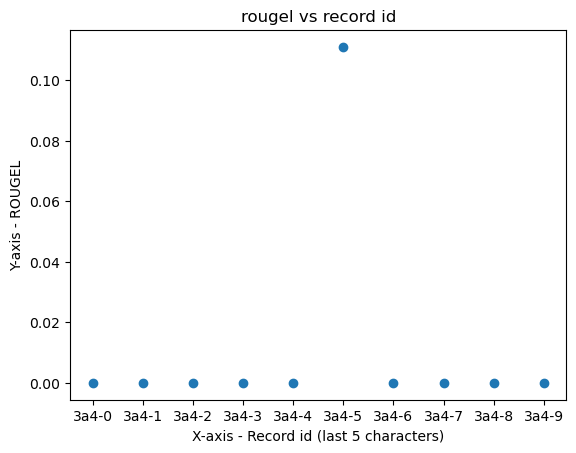

In [29]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - ROUGEL")
plt.title("rougel vs record id")

# Display the graph
plt.show()

In [30]:
DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True

url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL ,project_pta_id)

params = {
    "project_id":PROJECT_ID
}

payload = {
    "space_id": space_id
}
response = requests.post(url, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'74eb97ef-2ed6-423c-98e9-c1270809f516'

In [31]:
factsheets_url = f"{DATAPLATFORM_URL.replace('api.', '')}/wx/prompt-details/{project_pta_id}/factsheet?context=wx&project_id={PROJECT_ID}"

print(f"User can navigate to the published facts in project {factsheets_url}")

User can navigate to the published facts in project https://dataplatform.cloud.ibm.com/wx/prompt-details/e661e821-bf39-4279-86dc-b8c03b94f390/factsheet?context=wx&project_id=ab37b074-2174-4cba-ab6c-8545266e3cf2


In [32]:
DEPLOYMENTS_URL = WML_CREDENTIALS["url"] + "/ml/v4/deployments"

# serving_name = "summarization_deployment_detached" # eg: summary_deployment

payload = {
    "prompt_template": {
      "id": space_pta_id
    },
    "detached": {
    },
    "base_model_id": "google/flan-t5-base",
    "description": "summarization deployment",
    "name": "summarization deployment",
    "space_id": space_id
}

version = "2023-07-07" # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {
    "version":version,
    "space_id":space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

34335d1a-22bc-4bda-90fb-e55411bd83a7


In [33]:
label_column = "reference_summary"
operational_space_id = "pre_production"
problem_type= "summarization"
input_data_type= "unstructured_text"
monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration":{        
            }
        }
    },
}

response = wos_client.monitor_instances.mrm.execute_prompt_setup(prompt_template_asset_id = space_pta_id, 
                                                                   space_id = space_id,
                                                                   deployment_id = deployment_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 74eb97ef-2ed6-423c-98e9-c1270809f516 




running....
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '74eb97ef-2ed6-423c-98e9-c1270809f516',
 'space_id': '066d6f31-9f63-4498-aa17-cf8af695bac8',
 'deployment_id': '34335d1a-22bc-4bda-90fb-e55411bd83a7',
 'service_provider_id': '315c942e-7444-4c62-8143-1e7ca362ca50',
 'subscription_id': '72e75237-af37-49ac-b79c-cbd074beabbf',
 'mrm_monitor_instance_id': '995f3a0c-cbb3-436e-9212-cc54a119c419',
 'start_time': '2024-09-19T11:23:32.413344Z',
 'end_time': '2024-09-19T11:24:01.043356Z',
 'status': {'state': 'FINISHED'}}

In [34]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(prompt_template_asset_id = space_pta_id,
                                                             deployment_id = deployment_id,
                                                             space_id = space_id)

result = response.result
result_json = result._to_dict()
result_json

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method


{'prompt_template_asset_id': '74eb97ef-2ed6-423c-98e9-c1270809f516',
 'space_id': '066d6f31-9f63-4498-aa17-cf8af695bac8',
 'deployment_id': '34335d1a-22bc-4bda-90fb-e55411bd83a7',
 'service_provider_id': '315c942e-7444-4c62-8143-1e7ca362ca50',
 'subscription_id': '72e75237-af37-49ac-b79c-cbd074beabbf',
 'mrm_monitor_instance_id': '995f3a0c-cbb3-436e-9212-cc54a119c419',
 'start_time': '2024-09-19T11:23:32.413344Z',
 'end_time': '2024-09-19T11:24:01.043356Z',
 'status': {'state': 'FINISHED'}}

In [35]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'72e75237-af37-49ac-b79c-cbd074beabbf'